In [1]:
import matplotlib.pyplot as plt

import numpy as np
import ROOT, uproot
#root_numpy
from sklearn.model_selection import train_test_split
from sklearn import preprocessing


# import necessary keras modules/functions
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Flatten, Dense, Dropout, MaxPooling2D
from keras.layers import BatchNormalization, Activation, AveragePooling2D, Concatenate

from utils import PlotLearning

Welcome to JupyROOT 6.18/00


Using TensorFlow backend.


In [2]:
events = uproot.open("../FlatTree_Production/Z_Candidates_100k.root")["candidateTree"]
events.keys()

['nRecLep',
 'recLepPt1',
 'recLepEta1',
 'recLepPhi1',
 'recLepIsoVar1',
 'recLepCharge1',
 'recLepPDGID1',
 'recLepPt2',
 'recLepEta2',
 'recLepPhi2',
 'recLepIsoVar2',
 'recLepCharge2',
 'recLepPDGID2',
 'recLepInvMass',
 'genLepInvMass']

In [3]:
data = events.arrays(events.keys())

array = []
for i in events.keys():
    array.append(events.array(i))

array = np.array(array)

In [4]:
data = array.T
nBins=20
kappa=8
nvar=14
massMin=50
massMax=130
Z_mass=91.1876
epochs=50;
#[list(i) for i in root_numpy.tree2array(outTree, start=0, stop = n_events)]

x = np.array([i[:-1] for i in data])
y = np.array([i[-1] for i in data])
for i in range(len(y)):
    y[i]=np.trunc((y[i]-massMin)*nBins/(massMax-massMin))
ycat = keras.utils.to_categorical(y, nBins)

x = preprocessing.scale(x)
x_train, x_test, y_train, y_test = train_test_split(x, ycat, test_size=0.2, random_state=42)

print(x_train.shape)

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(ycat)[0]

(16384, 14)
('x_train shape:', (16384, 14, 1))
(16384, 'train samples')
(4096, 'test samples')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [5]:
model = Sequential()
#,input_shape=(64, nvar)
model.add(Dense(nvar,activation='linear',input_shape=(nvar,1)))
model.add(Flatten())
model.add(Dense(kappa*nBins**2,activation='relu'))
    
    # model.add(Dropout(0.25))
    # model.add(Dense(2*NBins,activation='relu'))
    # model.add(Dropout(0.5))
model.add(Dense(nBins,activation='softmax'))
model.summary()
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])

W0807 13:17:49.302167 140231096477504 deprecation_wrapper.py:119] From /home/aidanwiederhold/.local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0807 13:17:49.314867 140231096477504 deprecation_wrapper.py:119] From /home/aidanwiederhold/.local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0807 13:17:49.317231 140231096477504 deprecation_wrapper.py:119] From /home/aidanwiederhold/.local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0807 13:17:49.365015 140231096477504 deprecation_wrapper.py:119] From /home/aidanwiederhold/.local/lib/python2.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Opti

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 14, 14)            28        
_________________________________________________________________
flatten_1 (Flatten)          (None, 196)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3200)              630400    
_________________________________________________________________
dense_3 (Dense)              (None, 20)                64020     
Total params: 694,448
Trainable params: 694,448
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Define additional callbacks

def reduce_lr(patience_lr):
    reduce_lr_loss = keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.5, patience=patience_lr, verbose=1, min_delta=1e-4, mode='auto')
    return reduce_lr_loss

callbacks = [reduce_lr(patience_lr=20), PlotLearning()]

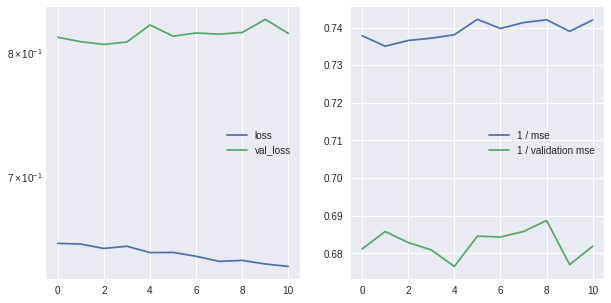

Epoch 12/50
16128/16384 [============================>.] - ETA: 0s - loss: 0.6353 - acc: 0.7431

In [ ]:
# 
history = model.fit(x_train, y_train, epochs=50, batch_size=64,  verbose=1, validation_data=(x_test, y_test), callbacks = callbacks)

In [8]:
model.predict(x_test)[0]

array([7.8528143e-07, 1.5384120e-07, 1.7051420e-07, 1.1337526e-07,
       6.2591582e-08, 3.0218050e-08, 2.9500307e-09, 8.6812912e-10,
       8.7249411e-08, 2.8451411e-02, 8.8252097e-01, 8.5599512e-02,
       2.6796937e-03, 6.7661062e-04, 5.6303965e-05, 8.3878540e-06,
       5.2033465e-06, 2.1190621e-07, 2.1584542e-08, 2.5302228e-07],
      dtype=float32)